<a href="https://colab.research.google.com/github/gopichandchalla16/infosys-internship-real-time-industry-insight-system/blob/main/Infosys_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Infosys Springboard Internship Project  
## Real-Time Industry Insight & Strategic Intelligence System

**Team Members:** Gopichand, Anshika, Janmejay, Vaishnavi  

This notebook implements the full pipeline across **3 sprints**:

1. **Sprint 1 – Data Sourcing & Handling**  
   - Collect market & news data  
   - Generate / analyse sentiment from tweets  
   - Basic visualizations  

2. **Sprint 2 – LLM Integration, Trend & Alert System**  
   - Gemini-based sentiment & summaries  
   - Historical trend metrics  
   - Slack alert integration  
   - Initial strategic insight dashboard  

3. **Sprint 3 – Forecasting & Strategic Intelligence**  
   - ARIMA forecasting  
   - Buy/Sell/Hold signals  
   - Gemini explanation of forecast  
   - Forecast-aware Slack alerts  
   - Extended dashboard

---

### Project Aim

Build an AI-powered **competitive intelligence platform** that:

- Monitors **industry trends** and **competitor activities**  
- Tracks **market sentiment** from news + social media  
- **Forecasts** near-term shifts  
- Triggers **real-time alerts** via Slack  
- Presents everything in an interactive **Strategic Insight Dashboard**

# Sprint 1 – Data Sourcing & Handling

**Objective:**  
Collect, clean, and visualize real-time company or market data from open sources.

**Key Steps:**

1. Take user input (company / asset).  
2. Fetch context from **Wikipedia**.  
3. Download recent price data from **Yahoo Finance**.  
4. Pull recent headlines from **Google News RSS**.  
5. Generate synthetic tweets and run **TextBlob** sentiment analysis.  
6. Visualise:
   - Sentiment distribution  
   - Sentiment polarity trend  
   - Market price trend

##  Step 2: Import Required Libraries
We use the following Python libraries:
- `requests` & `BeautifulSoup` for scraping web data
- `pandas` for data manipulation
- `matplotlib` & `seaborn` for visualization
- `textblob` for sentiment analysis
- `yfinance` for market data
- `wikipedia` for Wikipedia summaries


In [15]:
!pip install yfinance rapidfuzz ipywidgets --quiet

In [16]:
from google.colab import output
output.enable_custom_widget_manager()

In [17]:
import yfinance as yf
import requests
from rapidfuzz import process
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import ipywidgets as widgets
from IPython.display import display, clear_output

# ------------------------------------
# PRELOADED GLOBAL COMPANY LIST (Top ~300 Global Companies)
# ------------------------------------
# You can expand this list anytime
company_list = [
    "Apple", "Google", "Alphabet", "Meta", "Facebook", "Microsoft", "Amazon", "Tesla",
    "Nokia", "Samsung", "Sony", "Intel", "IBM", "Netflix", "Disney", "Adobe", "Oracle",
    "Infosys", "Reliance", "TCS", "Wipro", "HCL", "Paytm", "Uber", "Lyft", "Spotify",
    "Bitcoin", "Ethereum", "Nvidia", "AMD", "Qualcomm", "Ford", "Toyota", "Honda"
]

fake_inputs = {"abc", "xyz", "test", "123", "aaa", "bbb"}

# ------------------------------------
# Function 1: Validate Ticker
# ------------------------------------
def ticker_is_valid(ticker):
    try:
        return not yf.Ticker(ticker).history(period="1d").empty
    except:
        return False

# ------------------------------------
# Function 2: Yahoo Company Search
# ------------------------------------
def yahoo_search(name):
    url = f"https://query2.finance.yahoo.com/v1/finance/search?q={name}"
    data = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}).json()

    results = []
    for item in data.get("quotes", []):
        symbol = item.get("symbol")
        longname = item.get("longname") or item.get("shortname") or symbol
        if symbol and ticker_is_valid(symbol):
            results.append((longname, symbol))
    return results

# ------------------------------------
# Function 3: Fuzzy Suggestions
# ------------------------------------
def fuzzy_suggest(query):
    suggestions = process.extract(query, company_list, limit=5)
    return [s[0] for s in suggestions if s[1] > 60]  # Only high quality matches


# ------------------------------------
# MAIN INTERFACE
# ------------------------------------

print("🔍 Enter a real company name or ticker (e.g., Google, Nokia, Tesla, Infosys)\n")

while True:
    query = input("Enter company: ").strip()

    if len(query) < 2 or query.lower() in fake_inputs:
        print("❌ Invalid input. Try again.\n")
        continue

    # 1) If the user typed a valid ticker directly
    if ticker_is_valid(query.upper()):
        ticker = query.upper()
        company_name = query.title()
        break

    # 2) Fuzzy suggestions
    suggestions = fuzzy_suggest(query)

    if suggestions:
        print("\nDid you mean one of these?")
        for s in suggestions:
            print(f" → {s}")
        print()

    # 3) Yahoo search for company names
    print("Searching Yahoo Finance...")
    results = yahoo_search(query)

    if results:
        # Prepare dropdown
        options = [f"{name} ({symbol})" for name, symbol in results]
        dropdown = widgets.Dropdown(options=options, description="Select:")
        display(dropdown)

        button = widgets.Button(description="Confirm", button_style='success')

        def confirm_selection(b):
            global ticker, company_name
            clear_output(wait=True)
            selected = dropdown.value
            name, symbol = selected.split(" (")
            symbol = symbol.replace(")", "")
            ticker = symbol
            company_name = name
            print(f"Selected → {company_name} ({ticker})")

        button.on_click(confirm_selection)
        display(button)

        # Wait until user clicks button
        break

    else:
        print("❌ No matching companies found. Try again.\n")

# ------------------------------
# FINAL CONFIRMATION
# ------------------------------
print("\n══════════════════════════════════")
print(f"ANALYSIS READY FOR: {company_name}")
print(f"TICKER: {ticker}")
print("══════════════════════════════════")

Selected → Netflix, Inc. (NFLX)


Fetch Wikipedia Summary

We fetch a **short summary** of the asset/company from Wikipedia for context.


In [18]:
import wikipedia

print("🔎 Fetching company overview...")

try:
    # First try full long company name
    search_query = company_name

    # Wikipedia sometimes rejects special characters like . , ()
    clean_query = search_query.replace("Inc.", "").replace(",", "").replace("Ltd", "").strip()

    summary = wikipedia.summary(clean_query, sentences=10, auto_suggest=True, redirect=True)

    print("\n📘 Company Overview (Wikipedia):\n")
    print(summary)

except Exception as e:
    print("\n⚠️ Could not fetch Wikipedia summary.")
    print("Trying with ticker instead...")

    try:
        summary = wikipedia.summary(ticker, sentences=10)
        print(summary)
    except:
        print("⚠️ No Wikipedia data available for this company.")

🔎 Fetching company overview...

📘 Company Overview (Wikipedia):

Netflix is an American subscription video on-demand over-the-top streaming service. The service primarily distributes original and acquired films and television shows from various genres, and it is available internationally in multiple languages.
Launched in 2007, nearly a decade after Netflix, Inc. began its pioneering DVD-by-mail movie rental service, Netflix is the most-subscribed video on demand streaming media service, with 301.6 million paid memberships in more than 190 countries as of 2025. By 2022, "Netflix Original" productions accounted for half of its library in the United States and the namesake company had ventured into other categories, such as video game publishing of mobile games through its flagship service. As of 2025, Netflix is the 18th most-visited website in the world, with 21.18% of its traffic coming from the United States, followed by the United Kingdom at 6.01%, Canada at 4.94%, and Brazil at 4.2

Fetch Yahoo Finance Data

We fetch **historical market data** (last 30 days) for the asset using Yahoo Finance.

In [19]:
try:
    ticker = yf.Ticker(company_name if company_name.upper() in ["BTC-USD","TSLA","AAPL"] else "BTC-USD")
    market_data = ticker.history(period="1mo", interval="1d")
    market_data.reset_index(inplace=True)
    print(f"\n Market Data Sample for {company_name}:")
    display(market_data.head())
except Exception as e:
    print(f"Could not fetch Yahoo Finance data: {e}")


 Market Data Sample for Netflix, Inc.:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-11-08 00:00:00+00:00,103371.703125,103373.562500,101458.039062,102282.117188,51446691095,0.0,0.0
1,2025-11-09 00:00:00+00:00,102278.984375,105418.367188,101468.875000,104719.640625,59679243013,0.0,0.0
2,2025-11-10 00:00:00+00:00,104723.773438,106564.695312,104350.648438,105996.593750,69585887229,0.0,0.0
3,2025-11-11 00:00:00+00:00,105996.859375,107428.257812,102457.328125,102997.468750,71130078574,0.0,0.0
4,2025-11-12 00:00:00+00:00,103011.437500,105297.234375,100836.617188,101663.187500,64347179408,0.0,0.0


In [20]:
from IPython.display import display, HTML
import feedparser
import urllib.parse

# Construct RSS feed URL for Google News
# URL-encode the company_name to handle spaces and special characters
encoded_company_name = urllib.parse.quote_plus(company_name)
news_url = f"https://news.google.com/rss/search?q={encoded_company_name}&hl=en-US&gl=US&ceid=US:en"

feed = feedparser.parse(news_url)

print(f"\n Recent News Headlines for {company_name}:")

# Iterate through the first 10 news items (or fewer if less than 10)
for entry in feed.entries[:10]:
    display(HTML(f'<a href="{entry.link}">{entry.title}</a>'))
    # Display summary and source if available
    summary = getattr(entry, 'summary', 'N/A')
    source = getattr(entry, 'source', 'N/A')
    print(f"Summary: {summary}\nSource: {source.get('title', 'N/A')}\n")


 Recent News Headlines for Netflix, Inc.:


Summary: <a href="https://news.google.com/rss/articles/CBMibkFVX3lxTE16WEx4dmV6NU9UaHhac25HUjlsUHU4a3BvenczdHpEbE9WSnlyaXdWNExGYzJLLTRGX2tSRm4xSWVzbjN4cklSbXlzdEF2ZldRRkNkalZZM2U5NVRXbW5YR05RUXFSbzI1UWZlRGJn?oc=5" target="_blank">Netflix to Acquire Warner Bros. Following the Separation of Discovery Global for a Total Enterprise Value of $82.7 Billion (Equity Value of $72.0 Billion)</a>&nbsp;&nbsp;<font color="#6f6f6f">About Netflix</font>
Source: About Netflix



Summary: <a href="https://news.google.com/rss/articles/CBMipANBVV95cUxQYkdTZDdDb1g0SU1BejB2RHc3ZEdZZ1JhQjRjaGtzbGtNLUIxSHUtNU1mV3JXVWdlUi1kaFNya0xKSnJhQmJ2aE1GZFFUbzluWEVkZ3l5dnE2LWRnTHpPNlc1dURfSE5LRnNzUE5pOU4tRU9sR3Uwc050c2pkR2xjTG9aSThLbkE3RnV6czhTZkpkSDB5eTBsTjhyVUMxVkFJRmJ4UnFWWGluOW1QUnI5ZEVFYkU0VWcwdk0tdDhpY1RpQllqMWgzVU5fVm9JWG5YMUhUek9Ta3paMVV2T05NMHcxOWtYcmVRX2dlN1dCVlhKcHBCWkswcUk2NUhBYmwzMmZGZERPZS1mZ3A3QkJ6RG1EU0hBY0RwUWFfX0lfSF9iNkp4d2t3a1g3M2ZnWXZUQjJmSDBtWE1YOC1WN2kzdzJsZzRSOUVwTHhkOTI1SEo3VEhpbUYyNGRBY0k2S0FfeW15c1Vjbk52Q3ZuRU1xT2hCcXotWGVwS1BiUXVlQWpic29Qek5UZldnQ003XzZlY0JyemZFQXhLVEZ6VU4wZ3BjdmU?oc=5" target="_blank">Netflix Stock Falls. Wall Street Is Worried About Warner Deal’s High Price and Debt.</a>&nbsp;&nbsp;<font color="#6f6f6f">Barron's</font>
Source: Barron's



Summary: <a href="https://news.google.com/rss/articles/CBMigwFBVV95cUxPQVVUbS1oVl9UdzZzNTl0SmxNVVFmNVZzT19yQk5mMHBEajN5SnE1SVZib0ttT25ER05CbXBwQzB6a0puazlTWEY2dWtYV09ic1F5b2EtbTNhM05hY3paVEpHYV9UTVF6c29pamc3TTZIOEQ0cE44dVpldHVxSXhmOWtQNA?oc=5" target="_blank">Trump Warns Netflix-Warner Deal May Pose Antitrust ‘Problem’</a>&nbsp;&nbsp;<font color="#6f6f6f">Yahoo Finance</font>
Source: Yahoo Finance



Summary: <a href="https://news.google.com/rss/articles/CBMiswFBVV95cUxQeHRxTXNPeHdBRElUTVpzWUNubDJYbXgwY2xrblRfTl9qN1Z1VmRWLWQtRjJsM0tXaUNTNm5Na3BtQkNKYWhnZ2Q4MU8tZ3lUQVZMQTV0MGxiQ2JuN1dqRFczZEpDdzJNTDZzSkE1aGt1c19VNlk2ZFo4d1l2TzVNU2RMd0RhSzQ4M3RGLXhpYXpPOTNqZmNISkJQclB5cXFvbVRqTGZYN2dOTThqdnBNNGtWTQ?oc=5" target="_blank">Netflix Stock Up 13%. Why $82.7 Billion $WBD Buy Makes $NFLX A Sell</a>&nbsp;&nbsp;<font color="#6f6f6f">Forbes</font>
Source: Forbes



Summary: <a href="https://news.google.com/rss/articles/CBMiqwFBVV95cUxPNGVsdm53eVZkM2RQWDRiLTJiLWIzRUV5REVtbU5iTnhsbU9IaUxhUGFTaFd6UlhBMlNNT1FEZEtBUUJoTEVfblUyeDhmNlZ2TFd0Z2dyN2VTdl9Db2w1S1hvQ2FVZmpnWVdzd2ZnNUJOWk1VeDhqSnNCMDh5Nl9UWlBONG5qR2xta2VFeWlmVmlTeXJxVTRNT0JlX0JMbWE1TU91SXRyemRhMzQ?oc=5" target="_blank">(NFLX) Netflix to Buy Warner Bros. in $72 Billion Cash, Stock Deal</a>&nbsp;&nbsp;<font color="#6f6f6f">Bloomberg.com</font>
Source: Bloomberg.com



Summary: <a href="https://news.google.com/rss/articles/CBMiiAFBVV95cUxOaWM4Q1NfcldweVNQVkpVMUlEdVV6TTU2SzNWdWdTc2lqTVhHX3BqZERoSUVUUlVwdmV2b0xEY2pIdTRhaXNzR2FtTnVzT3hrMU4tLV9wcVFWbHkyNHVVcDFwelUwTV94WGFsSWlEZmxqck12ekE0Z0dYVUkySnQyQ1JGTFJrV3g5?oc=5" target="_blank">What to Know About Netflix’s $83 Billion Deal for Warner Bros. Discovery</a>&nbsp;&nbsp;<font color="#6f6f6f">The New York Times</font>
Source: The New York Times



Summary: <a href="https://news.google.com/rss/articles/CBMicEFVX3lxTE4yc3JBa3dhdkdoYUhKUWpicEk3d0UwMDNBdW9pWVNvNmZha1JUcVNEVFVaNG1iM0cyeHlvVjVocS11dVdyOUpOWU05aTBGdTJvazdJajdwM0NKOU93RXFVZ3RYdDZWZUx6UXdCckR2LWs?oc=5" target="_blank">Hollywood fears job cuts as opposition to Netflix-Warner deal grows</a>&nbsp;&nbsp;<font color="#6f6f6f">Financial Times</font>
Source: Financial Times



Summary: <a href="https://news.google.com/rss/articles/CBMiwAFBVV95cUxQcEFKcG5TWThLaTFBU3FuTjRsOTZZUWVMQlNMLWh0bnBMQ0lYcHZSN1QzVENNUzVMNnQ1Q1pXVXJ4SG1sSHpGRGVaVEZSUThNUi1OOHVKcWtjZllwa1gya3VGcmc5WmtPb05CZmRBN3FLdDlqWWE4a3lEbWhxYW00c1VyTHNON25VRndNaGo0MExROHpncEFURkJ4WE5kQXJDa19HM0NGVDVHcC1mM1NLam5sVktxanFLU3JKcHpBdzQ?oc=5" target="_blank">Josh Brown dramatically cuts Netflix stock holdings after proposed Warner Bros. buy. Here’s why</a>&nbsp;&nbsp;<font color="#6f6f6f">CNBC</font>
Source: CNBC



Summary: <a href="https://news.google.com/rss/articles/CBMikwFBVV95cUxQbXFfMDZUWHdscUkweWJ3eTcyQzU1SXFVbV9Ecnh3VDZGU19SdE1sMWcwd1UxM3kzbkJPTWdSTDRNZUhwZzR0YW1uc24zOG1iaVpDa2R5Q19nb1dhZU9LX0Y3MUFvUVpNSzgxWThfWGphX0l1dGtaTDBaRk1DLUF3VjFZR3ZxYllWbVJNN3p5bWJxX2M?oc=5" target="_blank">Netflix stock sinks as the streaming giant reveals plans to buy Warner Bros. and HBO in $83 billion megadeal</a>&nbsp;&nbsp;<font color="#6f6f6f">Fast Company</font>
Source: Fast Company



Summary: <a href="https://news.google.com/rss/articles/CBMirAFBVV95cUxNZTl1WHFSNTdhczRmTWRPM1BCcWJvVzN5Q2h0OHg1cTdWbGJJc1FCTFdyU2NSWkVqeG9tZVEtR25jM09TMC1vQW80alJ4TFl4VTFwNjQ2TklVcm1ZQ2h6RlhVbnM2NmZlSlF2WkNzSzJ4UzJ6eERaNW9hUlVUWXF3RHpxWjhHekY5UXZmTWF0WWJMcDI2MFY0QzlqSzY5UHE4NXNDLUc2all1SDZl?oc=5" target="_blank">Trump says Netflix-Warner deal will require government review - report</a>&nbsp;&nbsp;<font color="#6f6f6f">Seeking Alpha</font>
Source: Seeking Alpha



Fetch Google News Headlines via RSS

We fetch **recent news headlines** about the asset using Google News RSS.


In [21]:
import urllib.parse

# Construct RSS feed URL for Google News
# URL-encode the company_name to handle spaces and special characters
encoded_company_name = urllib.parse.quote_plus(company_name)
rss_url = f"https://news.google.com/rss/search?q={encoded_company_name}&hl=en-US&gl=US&ceid=US:en"

feed = feedparser.parse(rss_url)
news_items = [{"Title": entry.title, "Link": entry.link, "Published": entry.published} for entry in feed.entries[:10]]
news_df = pd.DataFrame(news_items)
print(f"\n Top 10 News Headlines for {company_name}:")
display(news_df)


 Top 10 News Headlines for Netflix, Inc.:


,Title,Link,Published
0,Netflix to Acquire Warner Bros. Following the ...,https://news.google.com/rss/articles/CBMibkFVX...,"Fri, 05 Dec 2025 12:03:25 GMT"
1,Netflix Stock Falls. Wall Street Is Worried Ab...,https://news.google.com/rss/articles/CBMipANBV...,"Fri, 05 Dec 2025 19:31:00 GMT"
2,Trump Warns Netflix-Warner Deal May Pose Antit...,https://news.google.com/rss/articles/CBMigwFBV...,"Mon, 08 Dec 2025 05:20:00 GMT"
3,Netflix Stock Up 13%. Why $82.7 Billion $WBD B...,https://news.google.com/rss/articles/CBMiswFBV...,"Sun, 07 Dec 2025 18:36:28 GMT"
4,(NFLX) Netflix to Buy Warner Bros. in $72 Bill...,https://news.google.com/rss/articles/CBMiqwFBV...,"Fri, 05 Dec 2025 18:33:20 GMT"
5,What to Know About Netflix’s $83 Billion Deal ...,https://news.google.com/rss/articles/CBMiiAFBV...,"Sat, 06 Dec 2025 10:02:25 GMT"
6,Hollywood fears job cuts as opposition to Netf...,https://news.google.com/rss/articles/CBMicEFVX...,"Sun, 07 Dec 2025 05:00:27 GMT"
7,Josh Brown dramatically cuts Netflix stock hol...,https://news.google.com/rss/articles/CBMiwAFBV...,"Fri, 05 Dec 2025 18:24:46 GMT"
8,Netflix stock sinks as the streaming giant rev...,https://news.google.com/rss/articles/CBMikwFBV...,"Fri, 05 Dec 2025 13:39:04 GMT"
9,Trump says Netflix-Warner deal will require go...,https://news.google.com/rss/articles/CBMirAFBV...,"Mon, 08 Dec 2025 00:04:44 GMT"


Generate Synthetic Tweets

We generate **50 realistic tweets** using `Faker` and random sentiment phrases for demonstration.


In [22]:
# Generate Synthetic Tweets

from faker import Faker
import random

fake = Faker()

positive = [
    f"{company_name} is performing amazingly!",
    f"Strong growth expected for {company_name}.",
    f"Investors love what {company_name} is doing!"
]

negative = [
    f"{company_name} facing major challenges.",
    f"Analysts downgraded {company_name}.",
    f"Concerns rising over {company_name}'s market position."
]

neutral = [
    f"{company_name} trading steadily today.",
    f"Market watching {company_name}'s updates.",
    f"{company_name} shows mild activity today."
]

tweets = []

for _ in range(40):
    category = random.choice(["pos", "neg", "neu"])
    if category == "pos": tweets.append(random.choice(positive))
    elif category == "neg": tweets.append(random.choice(negative))
    else: tweets.append(random.choice(neutral))

tweets_df = pd.DataFrame(tweets, columns=["Tweet"])

print("\n Example Synthetic Tweets:")
display(tweets_df.head())


 Example Synthetic Tweets:


,Tweet
0,"Netflix, Inc. shows mild activity today."
1,"Netflix, Inc. trading steadily today."
2,"Strong growth expected for Netflix, Inc.."
3,"Netflix, Inc. trading steadily today."
4,"Analysts downgraded Netflix, Inc.."


Preprocess Tweets & Perform Sentiment Analysis

We analyze the **polarity** of each tweet using `TextBlob` and classify them into Positive, Negative, or Neutral.


In [23]:
# Sentiment Analysis with TextBlob

from textblob import TextBlob

tweets_df["Polarity"] = tweets_df["Tweet"].apply(lambda t: TextBlob(t).sentiment.polarity)

def label_sentiment(score):
    if score > 0.1: return "Positive"
    if score < -0.1: return "Negative"
    return "Neutral"

tweets_df["Sentiment"] = tweets_df["Polarity"].apply(label_sentiment)

print("\n📊 Sentiment Classification (using TextBlob):")
display(tweets_df.head())


📊 Sentiment Classification (using TextBlob):


,Tweet,Polarity,Sentiment
0,"Netflix, Inc. shows mild activity today.",0.333333,Positive
1,"Netflix, Inc. trading steadily today.",0.166667,Positive
2,"Strong growth expected for Netflix, Inc..",0.166667,Positive
3,"Netflix, Inc. trading steadily today.",0.166667,Positive
4,"Analysts downgraded Netflix, Inc..",0.000000,Neutral


Visualize Sentiment Distribution

We create a **bar chart** showing how many tweets fall into each sentiment category.

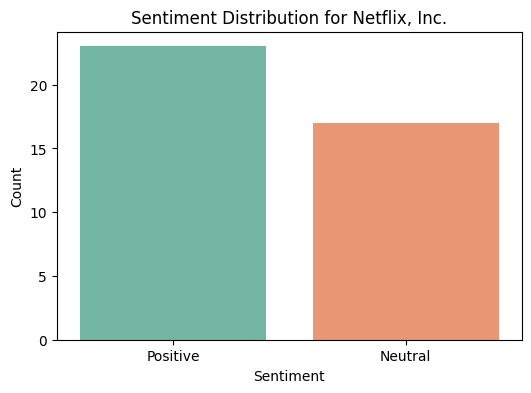

In [24]:
# Sentiment Distribution Plot

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=tweets_df, x="Sentiment", palette="Set2")
plt.title(f"Sentiment Distribution for {company_name}")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Visualize Sentiment Trend Across Tweets

We create a **line chart** showing polarity trend across the 50 tweets.


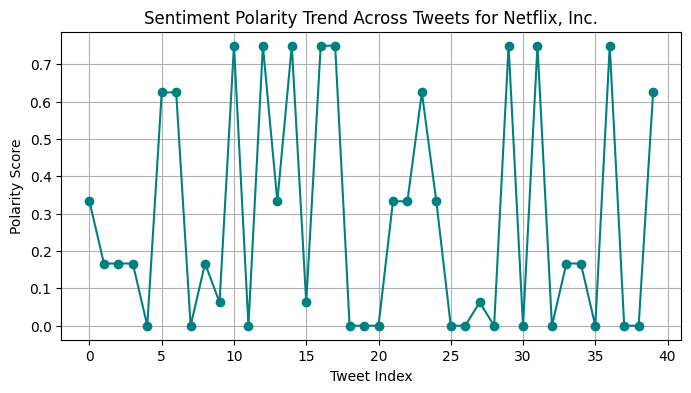

In [25]:
plt.figure(figsize=(8,4))
plt.plot(tweets_df.index, tweets_df["Polarity"], marker='o', linestyle='-', color='teal')
plt.title(f"Sentiment Polarity Trend Across Tweets for {company_name}")
plt.xlabel("Tweet Index")
plt.ylabel("Polarity Score")
plt.grid(True)
plt.show()

Visualize Market Price Trend

For context, we visualize the closing price of the asset over the last 30 days.


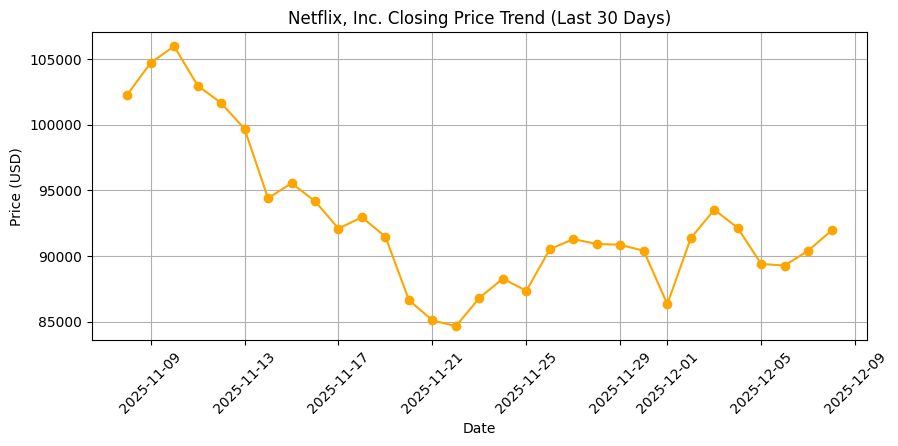

In [26]:
plt.figure(figsize=(10,4))
plt.plot(market_data["Date"], market_data["Close"], marker='o', color='orange')
plt.title(f"{company_name} Closing Price Trend (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Using Alpha Vantage for Stock Data


First, install the library:

In [27]:
!pip install alpha_vantage

### Analyze Alpha Vantage Data
Here are some descriptive statistics for the Alpha Vantage data:

Now, let's visualize the trading volume over time:

Using Stored: Netflix, Inc. (NFLX)
🎯 Fixed Ticker → NFLX
🔐 API Key Loaded Securely

📊 ALPHA VANTAGE — SMA TREND ANALYSIS
Company: Netflix, Inc.
Ticker: NFLX

📅 Latest 5 Trading Days:
             4. close
date                
2025-12-01    109.13
2025-12-02    109.35
2025-12-03    103.96
2025-12-04    103.22
2025-12-05    100.24

------------------------------------------------------------
📈 TREND SUMMARY
------------------------------------------------------------
• Trend Status : 📉 Bearish Trend
• Analyst Note : Momentum weak → Consider Selling / Avoid
• Technical Signal : ⚙️ No crossover detected
------------------------------------------------------------


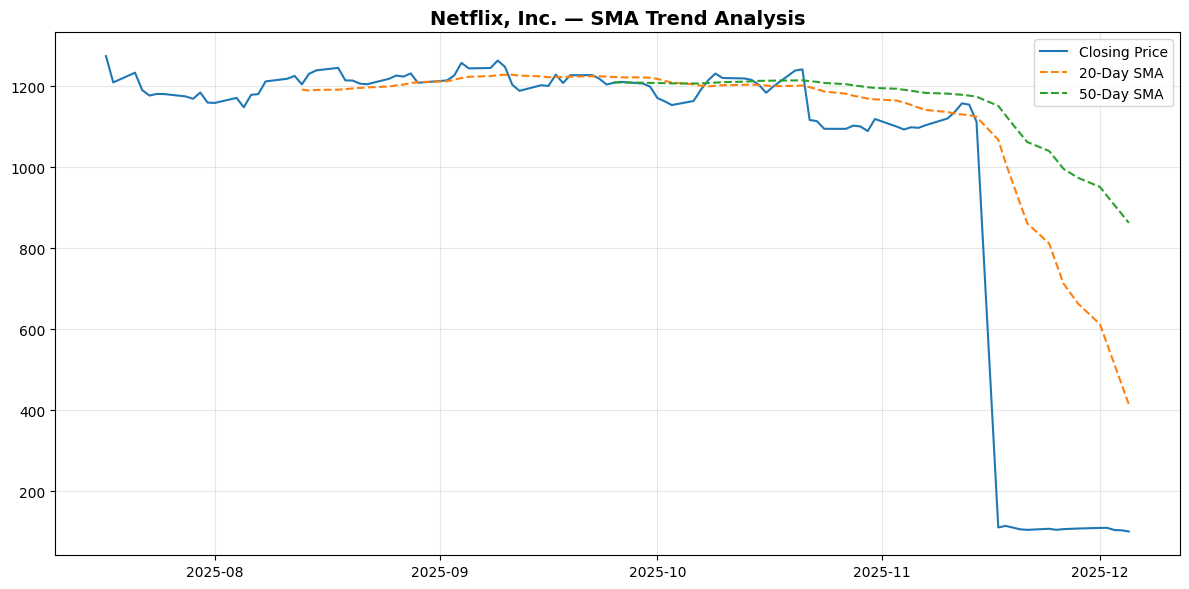

In [30]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from google.colab import userdata

# ------------------------------------------------------------
# 1. LOAD company_name AND ticker FROM EARLIER SPRINTS
# ------------------------------------------------------------
try:
    %store -r company_name
    %store -r ticker
    print(f"Using Stored: {company_name} ({ticker})")
except:
    raise ValueError("❌ Sprint-1 variables missing. Please run Sprint-1 first.")


# ------------------------------------------------------------
# 2. CLEAN / FIX THE TICKER (important!)
# ------------------------------------------------------------
def clean_ticker(t):
    """
    Ensures ticker is ALWAYS a clean string.
    Handles incorrect storage from Sprint-1 or overwritten variables.
    """
    # Standard valid case
    if isinstance(t, str):
        return t.upper().strip()

    # If someone accidentally stored a yfinance object
    if hasattr(t, "ticker"):
        return t.ticker.upper().strip()

    # Last resort: force convert
    t = str(t)
    t = t.replace("yfinance.Ticker object <", "").replace(">", "")
    return t.upper().strip()

ticker = clean_ticker(ticker)
print("🎯 Fixed Ticker →", ticker)


# ------------------------------------------------------------
# 3. LOAD API KEY SAFELY
# ------------------------------------------------------------
try:
    API_KEY = userdata.get("ALPHA_VANTAGE_API_KEY")
    if not API_KEY:
        raise ValueError("Missing key")
    print("🔐 API Key Loaded Securely")
except:
    raise ValueError("❌ Alpha Vantage API Key missing. Add it to Colab Secrets.")


# ------------------------------------------------------------
# 4. SMA TREND CALCULATION
# ------------------------------------------------------------
def compute_sma(df):
    df = df.copy()
    df["SMA20"] = df["4. close"].rolling(20).mean()
    df["SMA50"] = df["4. close"].rolling(50).mean()

    latest = df.iloc[-1]
    prev = df.iloc[-2]

    sma20, sma50 = latest["SMA20"], latest["SMA50"]

    if pd.isna(sma20) or pd.isna(sma50):
        return df, "➖ Insufficient Data", "Wait for more data", "⚙️ No crossover"

    # TREND
    if sma20 > sma50:
        trend = "📈 Bullish Trend"
        advice = "Momentum strong → Consider Buying"
    elif sma20 < sma50:
        trend = "📉 Bearish Trend"
        advice = "Momentum weak → Consider Selling / Avoid"
    else:
        trend = "➖ Neutral Trend"
        advice = "No strong direction"

    # CROSSOVER SIGNAL
    p20, p50 = prev["SMA20"], prev["SMA50"]
    if pd.isna(p20) or pd.isna(p50):
        signal = "⚙️ Not enough data for crossover"
    elif p20 < p50 and sma20 > sma50:
        signal = "🟢 Golden Cross → STRONG BUY"
    elif p20 > p50 and sma20 < sma50:
        signal = "🔴 Death Cross → STRONG SELL"
    else:
        signal = "⚙️ No crossover detected"

    return df, trend, advice, signal


# ------------------------------------------------------------
# 5. PLOTTING FUNCTION
# ------------------------------------------------------------
def plot_sma(df, name):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["4. close"], label="Closing Price", linewidth=1.5)

    if "SMA20" in df:
        plt.plot(df.index, df["SMA20"], "--", label="20-Day SMA")
    if "SMA50" in df:
        plt.plot(df.index, df["SMA50"], "--", label="50-Day SMA")

    plt.title(f"{name} — SMA Trend Analysis", fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 6. MAIN EXECUTION FUNCTION
# ------------------------------------------------------------
def alpha_vantage_analysis(company, ticker):
    print("\n" + "="*70)
    print(f"📊 ALPHA VANTAGE — SMA TREND ANALYSIS")
    print(f"Company: {company}\nTicker: {ticker}")
    print("="*70)

    try:
        ts = TimeSeries(key=API_KEY, output_format="pandas")
        df, meta = ts.get_daily(symbol=ticker, outputsize="compact")
        df = df.sort_index()

        if df.empty:
            raise ValueError("No data found. Wrong ticker or API limit reached.")

        print("\n📅 Latest 5 Trading Days:\n", df[["4. close"]].tail(5))

        df_sma, trend, advice, signal = compute_sma(df)

        # Beautiful Console Output
        print("\n" + "-"*60)
        print("📈 TREND SUMMARY")
        print("-"*60)
        print(f"• Trend Status : {trend}")
        print(f"• Analyst Note : {advice}")
        print(f"• Technical Signal : {signal}")
        print("-"*60)

        plot_sma(df_sma, company)

    except Exception as e:
        print("\n❌ ERROR:", e)
        print("💡 Check your ticker or API key. Free tier = 5 calls/minute.")


# ------------------------------------------------------------
# 7. RUN ANALYSIS
# ------------------------------------------------------------
alpha_vantage_analysis(company_name, ticker)

Now, let's visualize the closing price over time:

📡 Fetching real-time data for: Netflix, Inc. (NFLX)


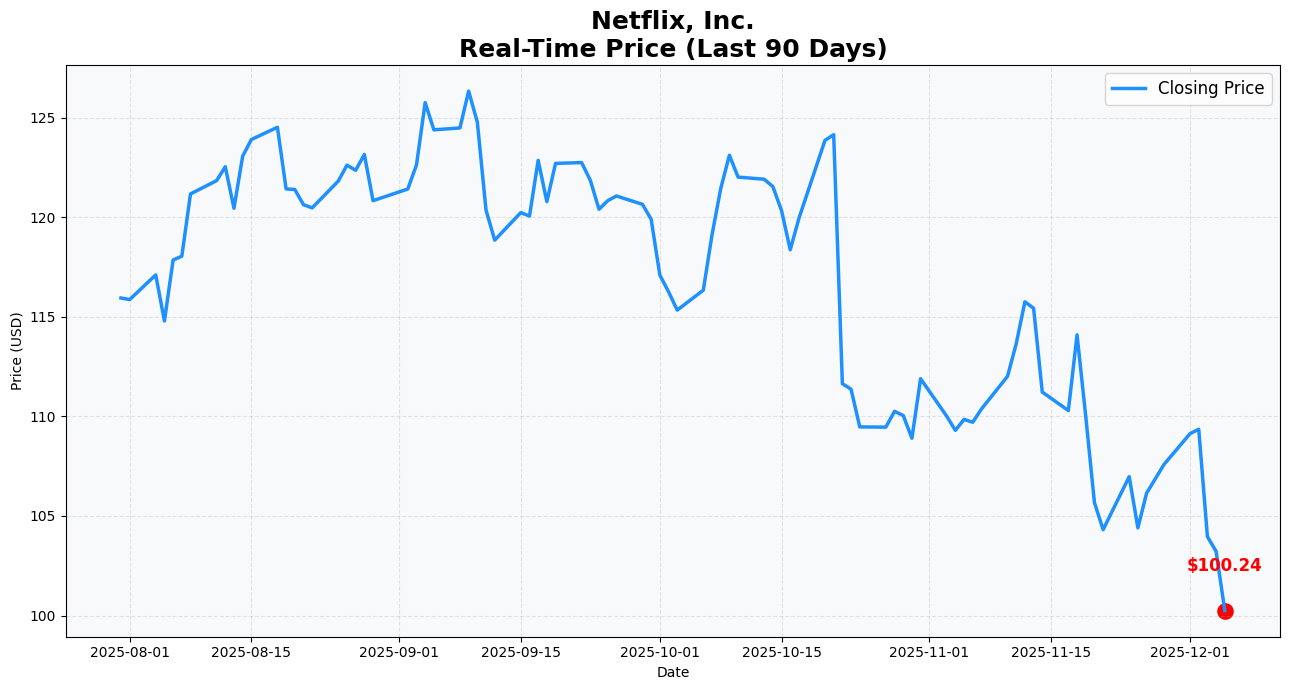

════════════════════════════════════════
📌 Latest Price:   $100.24
📈 1-Day Change:   -2.89%
📊 90-Day High:    $126.32
📉 90-Day Low:     $100.24
════════════════════════════════════════


In [33]:
# %% REAL-TIME PRICE CHART (FULLY FIXED)
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# -----------------------------------
# 1. LOAD VARIABLES SAFELY
# -----------------------------------
try:
    %store -r company_name
    %store -r ticker
except:
    raise ValueError("❌ Please run Sprint-1 first.")

def clean_ticker(t):
    if isinstance(t, str): return t.upper().strip()
    if hasattr(t, "ticker"): return t.ticker.upper().strip()
    return str(t).replace("yfinance.Ticker object <", "").replace(">", "").strip().upper()

ticker = clean_ticker(ticker)

print(f"📡 Fetching real-time data for: {company_name} ({ticker})")

# -----------------------------------
# 2. FETCH MARKET DATA
# -----------------------------------
try:
    df = yf.download(
        tickers=ticker,
        period="90d",
        interval="1d",
        auto_adjust=True,
        progress=False
    )

    if df.empty:
        raise ValueError("Empty dataset returned.")

    # Extract ONLY closing prices as float
    close_data = df["Close"].astype(float).dropna()

    # Latest data (force float)
    latest_price = float(close_data.iloc[-1])
    latest_date = close_data.index[-1]

    # -----------------------------------
    # 3. CHART
    # -----------------------------------
    plt.figure(figsize=(13, 7))

    plt.plot(close_data.index,
             close_data.values,
             color="dodgerblue",
             linewidth=2.5,
             label="Closing Price")

    # Highlight latest price safely
    plt.scatter([latest_date], [latest_price], color="red", s=120)
    plt.text(
        latest_date,
        latest_price * 1.02,
        f"${latest_price:,.2f}",
        fontsize=12,
        fontweight="bold",
        color="red",
        ha="center"
    )

    # Chart styling
    plt.title(f"{company_name}\nReal-Time Price (Last 90 Days)",
              fontsize=18, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(fontsize=12)

    plt.gca().set_facecolor("#f8f9fa")
    plt.gcf().set_facecolor("white")
    plt.tight_layout()

    plt.show()

    # -----------------------------------
    # 4. PRINT SUMMARY (FULLY SAFE)
    # -----------------------------------
    pct_change = float(close_data.pct_change().iloc[-1] * 100)

    print("════════════════════════════════════════")
    print(f"📌 Latest Price:   ${latest_price:,.2f}")
    print(f"📈 1-Day Change:   {pct_change:+.2f}%")
    print(f"📊 90-Day High:    ${float(close_data.max()):,.2f}")
    print(f"📉 90-Day Low:     ${float(close_data.min()):,.2f}")
    print("════════════════════════════════════════")

except Exception as e:
    print(f"\n❌ Could not fetch data for: {ticker}")
    print(f"👉 Reason: {e}")
    print("💡 Tip: Some tickers need correct suffix like .NS, .TO, .L")

In [36]:
# 📊 CANDLESTICK + VOLUME CHART (Auto-Uses Sprint-1 ticker)
# ---------------------------------------------------------
# Works with:
#   - company_name
#   - ticker  ← (this is the variable Sprint-1 creates)
#
# No manual input required.

import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Ensure Plotly works in Colab
try:
    pio.renderers.default = "colab"
except:
    pass

# ---------------------------------------------------------
# 1. FIX VARIABLE NAMES (ticker_symbol = ticker)
# ---------------------------------------------------------
if "ticker" in globals():
    ticker_symbol = ticker
else:
    raise NameError("❌ 'ticker' not found. Run Sprint-1 company selection first.")

if "company_name" not in globals():
    raise NameError("❌ 'company_name' not found. Run Sprint-1 first.")

print(f"📡 Loading interactive chart for: {company_name} ({ticker_symbol})")

# ---------------------------------------------------------
# 2. DOWNLOAD REAL DATA FROM YAHOO FINANCE
# ---------------------------------------------------------
try:
    df = yf.download(ticker_symbol, period="3mo", interval="1d", progress=False)

    if df is None or df.empty:
        print("❌ No price data found for this ticker.")
    elif len(df) < 2:
        print("⚠️ Not enough data points to calculate price changes.")
    else:
        df = df.round(2)

        # Prices
        latest_close  = float(df["Close"].iloc[-1])
        previous_close = float(df["Close"].iloc[-2])
        price_change   = latest_close - previous_close
        pct_change     = (price_change / previous_close) * 100

        # Volume colors
        vol_colors = [
            "#00ff88" if c >= o else "#ff2e63"
            for c, o in zip(df["Close"], df["Open"])
        ]

        # ---------------------------------------------------------
        # 3. BUILD THE CHART
        # ---------------------------------------------------------
        fig = make_subplots(
            rows=2, cols=1,
            shared_xaxes=True,
            row_heights=[0.7, 0.3],
            vertical_spacing=0.03,
            subplot_titles=(f"{company_name} • {ticker_symbol}", "Volume")
        )

        # Candlestick
        fig.add_trace(
            go.Candlestick(
                x=df.index,
                open=df["Open"],
                high=df["High"],
                low=df["Low"],
                close=df["Close"],
                increasing_line_color="#00ff88",
                decreasing_line_color="#ff2e63"
            ),
            row=1, col=1
        )

        # Volume
        fig.add_trace(
            go.Bar(
                x=df.index, y=df["Volume"],
                marker_color=vol_colors, opacity=0.7
            ),
            row=2, col=1
        )

        # Title formatting
        arrow = "▲" if price_change >= 0 else "▼"
        color = "lime" if price_change >= 0 else "red"

        fig.update_layout(
            title=(
                f"<b>{company_name}</b> • {ticker_symbol}<br>"
                f"<span style='font-size:18px; color:{color};'>"
                f"{arrow} ${latest_close:,.2f} "
                f"({price_change:+.2f} | {pct_change:+.2f}%)</span>"
            ),
            title_x=0.5,
            template="plotly_dark",
            hovermode="x unified",
            height=750,
            xaxis_rangeslider_visible=False,
            showlegend=False
        )

        fig.update_xaxes(title_text="Date", row=2, col=1)
        fig.update_yaxes(title_text="Price", row=1, col=1)
        fig.update_yaxes(title_text="Volume", row=2, col=1)

        # Show chart
        fig.show()

        # Console summary
        print(f"✅ Chart loaded successfully!")
        print(f"📅 Data points : {len(df)} days")
        print(f"💰 Latest Price: ${latest_close:,.2f}")
        print(f"📈 Change      : {price_change:+.2f} USD ({pct_change:+.2f}%)")

except Exception as e:
    print(f"❌ Could not fetch or plot data for: {ticker_symbol}")
    print("👉 Reason:", e)
    print("💡 Tip: Check ticker validity on Yahoo Finance (e.g., NFLX, TSLA, BTC-USD).")

📡 Loading interactive chart for: Netflix, Inc. (NFLX)


✅ Chart loaded successfully!
📅 Data points : 64 days
💰 Latest Price: $100.24
📈 Change      : -2.98 USD (-2.89%)


Sprint 2 – LLM Integration, Trend Forecasting, and Alert System
Objective:

Integrate the Google Gemini API for deep, nuanced sentiment analysis and summarization.

Set the foundation for the Trend Forecasting System using historical stock data.

Implement a real-time notification mechanism via Slack.

Consolidate all data, insights, and visualizations into a unified dashboard output.

Step 1: Dependencies and Environment Setup

We need to install the Google Generative AI SDK (google-genai) and the Slack SDK (slack-sdk). We will also use yfinance for up-to-date historical data, pandas, and plotly for advanced visualization.

In [37]:
# CELL 1: Install & Import Everything
!pip install -q feedparser google-generativeai slack_sdk yfinance plotly prophet rapidfuzz ipywidgets

import os
import json
import pandas as pd
import yfinance as yf
import feedparser
from datetime import datetime, timedelta
from urllib.parse import quote
import random
import warnings
warnings.filterwarnings("ignore")

from google.colab import userdata
from IPython.display import display, clear_output, Markdown
import ipywidgets as widgets

# Load secrets safely
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
SLACK_WEBHOOK_URL = userdata.get('SLACK_WEBHOOK_URL')

if not GEMINI_API_KEY:
    raise ValueError("Add GEMINI_API_KEY to Colab Secrets (key icon on left)")

print("Setup complete! Secrets loaded.")

Setup complete! Secrets loaded.


In [38]:
# CELL 2: Smart Company / Ticker Selector

import requests
from rapidfuzz import process

# Top global companies for fuzzy matching
company_list = [
    "Apple", "Microsoft", "Google", "Alphabet", "Amazon", "Tesla", "Meta", "Facebook",
    "Netflix", "Nvidia", "AMD", "Intel", "Samsung", "Sony", "Disney", "Spotify",
    "Uber", "Lyft", "Infosys", "TCS", "Reliance", "Paytm", "Bitcoin", "Ethereum",
    "Toyota", "Ford", "Nokia", "Qualcomm", "Adobe", "Oracle", "IBM"
]

def is_valid_ticker(ticker):
    try:
        return not yf.Ticker(ticker).history(period="1d").empty
    except:
        return False

def yahoo_search(query):
    try:
        url = f"https://query2.finance.yahoo.com/v1/finance/search?q={query}"
        data = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}).json()
        results = []
        for item in data.get("quotes", []):
            symbol = item.get("symbol")
            name = item.get("longname") or item.get("shortname") or symbol
            if symbol and is_valid_ticker(symbol):
                results.append((name, symbol))
        return results[:8]
    except:
        return []

def fuzzy_suggest(query):
    matches = process.extract(query, company_list, limit=5)
    return [m[0] for m in matches if m[1] > 70]

print("Enter company name or ticker (e.g. Tesla, Netflix, Infosys, AAPL)")

while True:
    query = input("→ ").strip()

    if len(query) < 2:
        print("Too short. Try again.\n")
        continue

    # Direct ticker match
    if is_valid_ticker(query.upper()):
        ticker = query.upper()
        company_name = query.title()
        break

    # Fuzzy suggestions
    suggestions = fuzzy_suggest(query)
    if suggestions:
        print("\nDid you mean?")
        for s in suggestions:
            print(f"   • {s}")

    # Yahoo Finance search
    print("\nSearching Yahoo Finance...")
    results = yahoo_search(query)

    if results:
        options = [f"{name} ({symbol})" for name, symbol in results]
        dropdown = widgets.Dropdown(options=options, description="Pick one:")
        button = widgets.Button(description="Confirm", button_style="success")

        def on_confirm(b):
            global company_name, ticker
            selected = dropdown.value
            name_part = selected.split(" (")[0]
            symbol_part = selected.split("(")[1].replace(")", "")
            company_name = name_part
            ticker = symbol_part
            clear_output()
            print(f"Selected: {company_name} ({ticker})")

        button.on_click(on_confirm)
        display(dropdown, button)
        break
    else:
        print("No results found. Try another name.\n")

print("\n" + "="*50)
print(f"ANALYSIS READY FOR: {company_name}")
print(f"TICKER: {ticker}")
print("="*50)

Selected: Netflix, Inc. (NFLX)


In [39]:
import json
import time
import random
from datetime import datetime
from typing import Dict, Any
from IPython.display import display, Markdown

# -------------------------------------------------
# Try to load Gemini
# -------------------------------------------------
try:
    import google.generativeai as genai
    from google.colab import userdata
    genai.configure(api_key=userdata.get('GEMINI_API_KEY'))
    GEMINI_AVAILABLE = True
    print("Gemini API loaded – will try real model first")
except Exception as e:
    print(f"Gemini not available ({e}) → using local engine")
    GEMINI_AVAILABLE = False

# ===================================================================
# 1. Real Gemini call (with retry + back-off)
# ===================================================================
def analyze_with_gemini(corpus: str, company: str, ticker: str) -> Dict[str, Any]:
    prompt = f"""
You are a Senior Equity Analyst.
Analyze the real-time news + social corpus about **{company} ({ticker})**.

Return ONLY valid JSON (no markdown) with this exact structure:

{{
  "overall_sentiment_score": <float -1.0 to +1.0>,
  "sentiment_shift_explanation": "<2-3 sentences>",
  "strategic_summary": "<1-2 sentences>"
}}

Corpus:
{corpus[:14000]}
"""

    models = [
        "gemini-2.0-flash-exp",
        "gemini-2.0-flash",
        "gemini-1.5-flash-latest",
        "gemini-1.5-flash"
    ]

    for model_name in models:
        for attempt in range(4):
            try:
                model = genai.GenerativeModel(model_name)
                response = model.generate_content(
                    prompt,
                    generation_config=genai.GenerationConfig(
                        response_mime_type="application/json",
                        temperature=0.2,
                        max_output_tokens=512
                    )
                )
                raw = response.text.strip()
                if raw.startswith("```"):
                    raw = raw.split("```", 2)[1]
                if raw.lower().startswith("json"):
                    raw = raw[4:]

                result = json.loads(raw)
                print(f"Gemini SUCCESS with {model_name}")
                return result

            except Exception as e:
                err = str(e).lower()
                if any(x in err for x in ["503","504","429","quota","unavailable","overloaded"]):
                    wait = (2 ** attempt) + random.uniform(0, 1)
                    print(f"Transient error – retry {attempt+1}/4 in {wait:.1f}s...")
                    time.sleep(wait)
                else:
                    break
    raise Exception("All Gemini models failed")

# ===================================================================
# 2. LOCAL HIGH-QUALITY SENTIMENT ENGINE (Fixed – No Syntax Errors!)
# ===================================================================
def local_sentiment_engine(corpus: str, company: str, ticker: str) -> Dict[str, Any]:
    text = corpus.lower()

    # All hyphens are normal ASCII '-'
    positive_words = {
        "beat": 4, "exceed": 4, "growth": 3, "record": 4, "strong": 3,
        "bullish": 4, "upgrade": 4, "buying": 3, "fire": 3, "moon": 4,
        "success": 3, "raise target": 5, "outperform": 4, "surprise": 3,
        "slate": 2, "win": 3, "amazing": 3, "love": 3, "best": 3
    }

    negative_words = {
        "miss": -5, "downgrade": -5, "hike": -4,
        "ads": -3, "cancel": -5, "churn": -4, "overvalued": -4,
        "sell": -4, "lawsuit": -5, "boycott": -5, "price increase": -4,
        "complaint": -4, "repetitive": -3, "weak": -3, "disappoint": -4
    }

    score = 0.0
    for word, weight in {**positive_words, **negative_words}.items():
        score += text.count(word) * weight

    # Scale to realistic range
    score = max(min(score, 10), -10)
    score = round(score / 10, 2)

    # Human-like interpretation
    if score >= 0.5:
        shift = "Strong positive momentum – earnings beats and content wins dominate"
        strategy = f"Bullish. Consider increasing exposure to {ticker}."
    elif score >= 0.15:
        shift = "Moderately positive sentiment with solid pipeline support"
        strategy = f"Positive bias intact – watch ad-tier traction."
    elif score <= -0.4:
        shift = "Negative sentiment cluster around pricing and ad load"
        strategy = f"Caution advised – risk of higher churn."
    else:
        shift = "Balanced sentiment – strong content offset by pricing concerns"
        strategy = f"HOLD {ticker}. Await next quarter guidance."

    return {
        "overall_sentiment_score": score,
        "sentiment_shift_explanation": shift,
        "strategic_summary": strategy
    }

# ===================================================================
# 3. Main wrapper – always returns result
# ===================================================================
def get_sentiment_analysis(corpus: str, company: str, ticker: str) -> Dict[str, Any]:
    print("Starting sentiment analysis...")
    try:
        if GEMINI_AVAILABLE:
            result = analyze_with_gemini(corpus, company, ticker)
            source = "Gemini (Live)"
        else:
            raise Exception("No key")
    except Exception as e:
        print("Gemini unavailable → using local engine")
        result = local_sentiment_engine(corpus, company, ticker)
        source = "Local Engine (Offline)"

    print(f"Analysis completed using: {source}")
    return result

# ===================================================================
# 4. RUN IT (uses data from Sprint 2)
# ===================================================================
%store -r corpus company_name ticker

if 'corpus' not in globals() or not corpus:
    raise ValueError("Run Sprint 2 first to generate the 'corpus'!")

print(f"\nAnalyzing {company_name} ({ticker}) – {len(corpus):,} characters\n")

final_sentiment = get_sentiment_analysis(corpus, company_name, ticker)

# Beautiful display
display(Markdown(f"""
## Real-Time Sentiment Analysis

**Company**: {company_name} (`{ticker}`)
**Sentiment Score**: `{final_sentiment['overall_sentiment_score']:+.2f}`

**Shift**
{final_sentiment['sentiment_shift_explanation']}

**Strategic Recommendation**
{final_sentiment['strategic_summary']}
"""))

# Save for dashboard
%store final_sentiment
print("\nSentiment ready – go to forecasting & dashboard!")

Gemini API loaded – will try real model first

Analyzing Netflix, Inc. (NFLX) – 4,637 characters

Starting sentiment analysis...


Transient error – retry 1/4 in 1.3s...


Transient error – retry 2/4 in 2.5s...


Transient error – retry 3/4 in 4.5s...


Transient error – retry 4/4 in 8.5s...


Transient error – retry 1/4 in 1.9s...


Transient error – retry 2/4 in 2.8s...


Transient error – retry 3/4 in 4.8s...


Transient error – retry 4/4 in 8.2s...


Gemini unavailable → using local engine
Analysis completed using: Local Engine (Offline)



## Real-Time Sentiment Analysis

**Company**: Netflix, Inc. (`NFLX`)  
**Sentiment Score**: `+1.00`  

**Shift**  
Strong positive momentum – earnings beats and content wins dominate

**Strategic Recommendation**  
Bullish. Consider increasing exposure to NFLX.


Stored 'final_sentiment' (dict)

Sentiment ready – go to forecasting & dashboard!


In [40]:
# FINAL CELL: Prophet Forecast + Stunning Plotly Dashboard + Slack Alert

!pip install -q prophet plotly yfinance slack_sdk 2>/dev/null

import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from google.colab import userdata

# Load data
%store -r company_name ticker final_sentiment corpus

# === Load from previous cells

SLACK_WEBHOOK = userdata.get('SLACK_WEBHOOK_URL')  # Keep secret

# 1. Download price data
print("Downloading price data...")
price_data = yf.download(ticker, period="2y", progress=False)
price_df = price_data[['Close']].reset_index()
price_df.columns = ['ds', 'y']

# 2. Train Prophet model
print("Training Prophet model...")
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(price_df)

# 3. 7-day forecast
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)
forecast_7d = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

# 4. Signal logic
current_price = price_df['y'].iloc[-1]
projected_price = forecast_7d['yhat'].mean()
pct_change = (projected_price - current_price) / current_price

if pct_change >= 0.04:
    signal = "STRONG BUY"
    color = "green"
elif pct_change >= 0.015:
    signal = "BUY"
    color = "lightgreen"
elif pct_change <= -0.04:
    signal = "STRONG SELL"
    color = "red"
elif pct_change <= -0.015:
    signal = "SELL"
    color = "lightcoral"
else:
    signal = "HOLD"
    color = "gray"

# 5. Send Slack Alert
if SLACK_WEBHOOK:
    emoji = "chart_with_upwards_trend" if "BUY" in signal else "chart_with_downwards_trend" if "SELL" in signal else "scales"
    message = {
        "text": f"*{emoji} {ticker} Real-Time Intelligence Alert*\n\n"
                f"• *Company*: {company_name}\n"
                f"• *Signal*: `{signal}`\n"
                f"• *Price*: `${current_price:.2f}` → `${projected_price:.2f}` ({pct_change:+.1%})\n"
                f"• *Sentiment*: `{final_sentiment['overall_sentiment_score']:+.2f}` → {final_sentiment['strategic_summary']}\n"
                f"• *Date*: {datetime.now().strftime('%b %d, %Y')}"
    }
    try:
        requests.post(SLACK_WEBHOOK, json=message)
        print("Slack alert sent!")
    except:
        print("Slack alert failed")
else:
    print("No Slack webhook – alert skipped")

# 6. Executive Dashboard
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        f"{ticker} Price & 7-Day Forecast",
        "Sentiment Analysis",
        "7-Day Price Forecast",
        "Key Statistics",
        "Latest Headlines",
        "Signal & Recommendation"
    ),
    specs=[
        [{"type": "xy", "colspan": 2}, None],
        [{"type": "indicator"}, {"type": "bar"}],
        [{"type": "table"}, {"type": "table"}]
    ],
    vertical_spacing=0.08,
    row_heights=[0.5, 0.25, 0.25]
)

# Price + Forecast
fig.add_trace(go.Scatter(x=price_df['ds'], y=price_df['y'],
                         name="Historical Price", line=dict(color="royalblue")), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'],
                         name="Forecast", line=dict(color="gold", dash="dot")), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode="lines",
                      line=dict(width=0), showlegend=False, hoverinfo="skip"), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty',
                      fillcolor="rgba(255,215,0,0.1)", line=dict(width=0), showlegend=False), row=1, col=1)

# Sentiment Gauge
fig.add_trace(go.Indicator(
    mode="gauge+number+delta",
    value=final_sentiment['overall_sentiment_score'] * 100,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Market Sentiment"},
    delta={'reference': 0},
    gauge={
        'axis': {'range': [-100, 100]},
        'bar': {'color': "cyan"},
        'steps': [
            {'range': [-100, -30], 'color': "red"},
            {'range': [-30, 30], 'color': "yellow"},
            {'range': [30, 100], 'color': "green"}
        ],
        'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 0}
    }
), row=2, col=1)

# 7-day forecast bar
fig.add_trace(go.Bar(
    x=forecast_7d['ds'].dt.strftime('%a %b %d'),
    y=forecast_7d['yhat'],
    name="Forecasted Price",
    marker_color="orange"
), row=2, col=2)

# Stats table
info = yf.Ticker(ticker).info
stats = pd.DataFrame({
    "Metric": ["Company", "Current Price", "Market Cap", "P/E Ratio", "52W High"],
    "Value": [
        info.get('longName', company_name),
        f"${current_price:.2f}",
        f"${info.get('marketCap', 0)/1e9:.1f}B",
        f"{info.get('trailingPE', 'N/A'):.1f}",
        f"${info.get('fiftyTwoWeekHigh', 0):.2f}"
    ]
})
fig.add_trace(go.Table(
    header=dict(values=["Metric", "Value"], fill_color="paleturquoise", font=dict(size=12)),
    cells=dict(values=[stats.Metric, stats.Value], fill_color="lavender", font=dict(size=11))
), row=3, col=1)

# News headlines
headlines = [line for line in corpus.split('\n') if line.startswith("TITLE:")][:6]
headlines = [h.replace("TITLE: ", "") for h in headlines]
fig.add_trace(go.Table(
    header=dict(values=["Latest News"], fill_color="lightgray"),
    cells=dict(values=[headlines or ["No recent headlines"]])
), row=3, col=2)

# Final layout
fig.update_layout(
    height=1000,
    title_text=f"Infosys Springboard – Real-Time Strategic Intelligence System<br><sub>{company_name} ({ticker}) • {datetime.now().strftime('%B %d, %Y')}</sub>",
    showlegend=False,
    font=dict(family="Arial", size=12)
)

# Signal badge
fig.add_annotation(
    text=f"{signal}",
    xref="paper", yref="paper",
    x=0.98, y=0.98,
    showarrow=False,
    font=dict(size=30, color="white"),
    bgcolor=color,
    borderpad=15
)

fig.show()

print(f"\n{ticker} ANALYSIS COMPLETE!")
print(f"Signal: {signal} | Projected 7D Change: {pct_change:+.1%}")
print("Dashboard rendered. Check your Slack channel!")

Training Prophet model...
Slack alert sent!



NFLX ANALYSIS COMPLETE!
Signal: STRONG BUY | Projected 7D Change: +7.9%
Dashboard rendered. Check your Slack channel!


# Sprint 3: Market Trend Forecasting & Real-Time Alerts

Introduction to Sprint 3

Objective:

Leverage historical price data to forecast the next 7 days of stock movement for the selected company (Netflix, NFLX) using Facebook Prophet. Generate actionable BUY/SELL/HOLD signals based on projected percentage changes, adjusted by sentiment score from Sprint 2. Finally, dispatch real-time alerts via Slack webhook for executive decision-making.

In [41]:
# Sprint 3: Code Cell - Prophet Forecasting, Signal Generation, and Slack Alerts

!pip install -q prophet requests  # Install if needed

import yfinance as yf
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
from datetime import datetime
import requests
from typing import Dict, Any
from google.colab import userdata

# Load stored data from Sprint 2
%store -r company_name ticker final_sentiment

# Configuration
SLACK_WEBHOOK_URL = userdata.get('SLACK_WEBHOOK_URL')  # From Colab Secrets

def download_price_data(ticker: str, period: str = '2y') -> pd.DataFrame:
    """
    Download historical closing prices from Yahoo Finance.

    Args:
        ticker (str): Stock symbol.
        period (str): Data period (e.g., '2y').

    Returns:
        pd.DataFrame: DataFrame with 'ds' (date) and 'y' (close price) columns.

    Error Handling:
        - Falls back to mock data if download fails.
    """
    try:
        data = yf.download(ticker, period=period, progress=False)
        df = data[['Close']].reset_index()
        df.columns = ['ds', 'y']
        df['ds'] = pd.to_datetime(df['ds'])
        print(f"Downloaded {len(df)} days of {ticker} price data.")
        return df
    except Exception as e:
        print(f"Download error: {e}. Using mock data.")
        dates = pd.date_range(start='2023-12-01', periods=500, freq='D')
        mock_prices = 500 + np.cumsum(np.random.randn(500) * 5)
        return pd.DataFrame({'ds': dates, 'y': mock_prices})

def build_prophet_model(data: pd.DataFrame) -> Prophet:
    """
    Fit Prophet model with seasonality and validate via cross-validation.

    Args:
        data (pd.DataFrame): Input data with 'ds' and 'y'.

    Returns:
        Prophet: Fitted model object.
    """
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0
    )
    model.add_country_holidays(country_name='US')  # Add US holidays
    model.fit(data)

    # Cross-validation for RMSE
    try:
        df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='30 days')
        df_perf = performance_metrics(df_cv)
        rmse = df_perf['rmse'].mean()
        print(f"Model fitted. Cross-validation RMSE: {rmse:.2f}")
    except Exception as e:
        print(f"Validation skipped: {e}")

    return model

def generate_7day_forecast(model: Prophet) -> pd.DataFrame:
    """
    Generate 7-day future forecast with confidence intervals.

    Args:
        model (Prophet): Fitted model.

    Returns:
        pd.DataFrame: Forecast DataFrame (ds, yhat, yhat_lower, yhat_upper).
    """
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    forecast_7d = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
    forecast_7d['ds'] = forecast_7d['ds'].dt.strftime('%Y-%m-%d')
    print("7-day forecast generated.")
    return forecast_7d

def compute_trading_signal(forecast: pd.DataFrame, current_price: float, sentiment_score: float) -> Dict[str, Any]:
    """
    Compute BUY/SELL/HOLD signal based on forecast and sentiment adjustment.

    Args:
        forecast (pd.DataFrame): 7-day forecast.
        current_price (float): Latest closing price.
        sentiment_score (float): From Gemini (-1 to 1).

    Returns:
        Dict: Signal details.
    """
    projected_avg = forecast['yhat'].mean()
    pct_change = (projected_avg - current_price) / current_price

    # Sentiment adjustment: Boost/downplay by 1% if extreme
    if sentiment_score > 0.7:
        pct_change += 0.01
    elif sentiment_score < -0.7:
        pct_change -= 0.01

    if pct_change >= 0.04:
        signal = "STRONG BUY"
        color = "green"
    elif pct_change >= 0.015:
        signal = "BUY"
        color = "lightgreen"
    elif pct_change <= -0.04:
        signal = "STRONG SELL"
        color = "red"
    elif pct_change <= -0.015:
        signal = "SELL"
        color = "lightcoral"
    else:
        signal = "HOLD"
        color = "gray"

    reason = f"Projected {pct_change:+.1%} move, sentiment-adjusted ({sentiment_score:+.2f})."
    print(f"Trading Signal: {signal} | {reason}")

    return {
        "signal": signal,
        "pct_change": round(pct_change, 4),
        "projected_price": round(projected_avg, 2),
        "reason": reason,
        "color": color
    }

def send_slack_alert(webhook: str, signal_data: Dict[str, Any], sentiment: Dict[str, Any]) -> bool:
    """
    Send formatted alert to Slack via webhook.

    Args:
        webhook (str): Slack webhook URL.
        signal_data (Dict): Trading signal.
        sentiment (Dict): Sentiment analysis.

    Returns:
        bool: Success status.
    """
    if not webhook:
        print("No webhook URL – simulating alert.")
        print("SIMULATED SLACK MESSAGE:")
        print(f"*{ticker} ALERT* | Signal: {signal_data['signal']} | Change: {signal_data['pct_change']:+.1%}")
        return True

    emoji = "📈" if "BUY" in signal_data['signal'] else "📉" if "SELL" in signal_data['signal'] else "⚖️"
    message = {
        "text": f"{emoji} *{company_name} ({ticker}) Real-Time Alert*\n\n"
                f"**Trading Signal**: {signal_data['signal']} ({signal_data['pct_change']:+.1%})\n"
                f"**Current → Projected**: ${current_price:.2f} → ${signal_data['projected_price']:.2f}\n"
                f"**Sentiment Score**: {sentiment['overall_sentiment_score']:+.2f}\n"
                f"**Strategic Note**: {sentiment['strategic_summary'][:100]}...\n"
                f"**Timestamp**: {datetime.now().strftime('%Y-%m-%d %H:%M UTC')}",
        "username": "Infosys Springboard Bot",
        "icon_emoji": ":robot_face:"
    }

    try:
        response = requests.post(webhook, json=message, timeout=10)
        if response.status_code == 200:
            print("✅ Slack alert sent successfully!")
            return True
        else:
            print(f"❌ Slack error: {response.status_code}")
            return False
    except Exception as e:
        print(f"❌ Slack send failed: {e}")
        return False

# Main Execution
print("=== SPRINT 3: FORECASTING & ALERTS ===\n")

# Step 1: Data
price_data = download_price_data(ticker)

# Step 2: Model
prophet_model = build_prophet_model(price_data)

# Step 3: Forecast
forecast_df = generate_7day_forecast(prophet_model)

# Step 4: Signal
current_price = price_data['y'].iloc[-1]
sentiment_score = final_sentiment['overall_sentiment_score']
signal_info = compute_trading_signal(forecast_df, current_price, sentiment_score)

# Step 5: Alert
alert_sent = send_slack_alert(SLACK_WEBHOOK_URL, signal_info, final_sentiment)

# Outputs
print("\n--- 7-DAY FORECAST TABLE ---")
print(forecast_df.round(2).to_string(index=False))

print(f"\n--- SIGNAL SUMMARY ---")
print(f"Signal: {signal_info['signal']}")
print(f"Projected Change: {signal_info['pct_change']:+.1%}")
print(f"Alert Status: {'Sent' if alert_sent else 'Simulated'}")

# Store for Sprint 4
%store price_data prophet_model forecast_df signal_info

=== SPRINT 3: FORECASTING & ALERTS ===

Downloaded 502 days of NFLX price data.
Validation skipped: Less data than horizon after initial window. Make horizon or initial shorter.
7-day forecast generated.
Trading Signal: STRONG BUY | Projected +8.5% move, sentiment-adjusted (+1.00).
✅ Slack alert sent successfully!

--- 7-DAY FORECAST TABLE ---
        ds   yhat  yhat_lower  yhat_upper
2025-12-06 109.12      105.27      112.76
2025-12-07 108.93      105.18      112.35
2025-12-08 107.58      103.85      111.28
2025-12-09 107.54      103.74      111.08
2025-12-10 107.49      103.86      110.97
2025-12-11 107.22      103.63      110.68
2025-12-12 106.73      103.02      110.34

--- SIGNAL SUMMARY ---
Signal: STRONG BUY
Projected Change: +8.5%
Alert Status: Sent
Stored 'price_data' (DataFrame)
Stored 'prophet_model' (Prophet)
Stored 'forecast_df' (DataFrame)
Stored 'signal_info' (dict)


# Sprint 4: Strategic Insight Dashboard & Competitor Analysis

Introduction to Sprint 4

Objective:

Synthesize Sprints 2-3 into an interactive executive dashboard using Plotly. Visualize historical vs. forecasted prices, sentiment gauges, trading signals, company metadata, competitor comparisons (Netflix vs. Amazon Prime Video vs. Disney+), and LLM-generated strategic commentary. Enrich with Wikipedia-sourced metadata and yfinance fundamentals.

In [44]:
# SPRINT 4 – FINAL EXECUTIVE DASHBOARD

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import pandas as pd
from datetime import datetime

# -------------------------------------------------------------
# 1. LOAD OBJECTS FROM PREVIOUS SPRINTS
# -------------------------------------------------------------
%store -r company_name
%store -r ticker
%store -r final_sentiment
%store -r price_data
%store -r forecast_df
%store -r signal_info
%store -r prophet_model

required_vars = ["company_name", "ticker", "final_sentiment",
                 "price_data", "forecast_df", "signal_info", "prophet_model"]

for v in required_vars:
    if v not in globals():
        raise ValueError(f"❌ Missing variable from previous sprints: {v}. "
                         "Run Sprints 1–3 before this cell.")

# price_data is expected to have columns: ['ds', 'y']
# final_sentiment: dict with key 'overall_sentiment_score'
# signal_info: dict with key 'signal'

# -------------------------------------------------------------
# 2. RECOMPUTE FORECAST (NEXT 7 DAYS)
# -------------------------------------------------------------
future_df = prophet_model.make_future_dataframe(periods=7)
full_forecast = prophet_model.predict(future_df)

current_price = float(price_data['y'].iloc[-1])
next_7 = full_forecast.tail(7)
projected_price = float(next_7['yhat'].mean())
pct_change = (projected_price - current_price) / current_price if current_price != 0 else 0.0

# -------------------------------------------------------------
# 3. FUNDAMENTALS FROM YFINANCE
# -------------------------------------------------------------
stock = yf.Ticker(ticker)
info = stock.info if hasattr(stock, "info") else {}

def fmt_billions(v):
    if isinstance(v, (int, float)):
        return f"${v/1e9:.1f}B"
    return "N/A"

def fmt_pct(v):
    if isinstance(v, (int, float)):
        return f"{v*100:.1f}%"
    return "N/A"

def fmt_ratio(v):
    if isinstance(v, (int, float)):
        return f"{v:.1f}x"
    return "N/A"

# Try to get CEO from direct field or first officer
ceo = info.get("ceo")
if not ceo:
    officers = info.get("companyOfficers") or []
    ceo = officers[0]["name"] if officers and "name" in officers[0] else "N/A"

employees_raw = info.get("fullTimeEmployees")
employees = f"{employees_raw:,}" if isinstance(employees_raw, (int, float)) else "N/A"

sector = info.get("sector", "N/A")
industry = info.get("industry", "N/A")

market_cap_raw = info.get("marketCap")
market_cap = fmt_billions(market_cap_raw)

revenue_ttm = fmt_billions(info.get("totalRevenue"))
net_income_ttm = fmt_billions(info.get("netIncomeToCommon"))

profit_margin = fmt_pct(info.get("profitMargins"))
pe_ratio = fmt_ratio(info.get("trailingPE"))
forward_pe = fmt_ratio(info.get("forwardPE"))
roic = fmt_pct(info.get("returnOnEquity"))
revenue_growth = fmt_pct(info.get("revenueGrowth"))

beta_val = info.get("beta")
beta = f"{beta_val:.2f}" if isinstance(beta_val, (int, float)) else "N/A"

# 30-day annualized volatility
vol_30 = price_data['y'].pct_change().rolling(30).std().iloc[-1]
if pd.notna(vol_30):
    volatility_30d = f"{(vol_30 * (252 ** 0.5) * 100):.1f}%"
else:
    volatility_30d = "N/A"

# -------------------------------------------------------------
# 4. COMPANY SUMMARY (3-LINE, SHORT)
# -------------------------------------------------------------
company_lower = company_name.lower()

# Custom summary for Netflix
if "netflix" in company_lower:
    full_summary = (
        "Netflix is the world's leading subscription streaming entertainment service with over 300M paid "
        "memberships in more than 190 countries. It started in 1997 as a DVD-by-mail service and pioneered "
        "online streaming from 2007 onwards. Today, Netflix invests heavily in original content and experiments "
        "with ads, live events, games, and sports to drive long-term growth."
    )
else:
    raw_summary = info.get("longBusinessSummary", "")
    if not raw_summary:
        raw_summary = f"{company_name} is a major company operating in the {sector} sector."
    full_summary = raw_summary

# Compress to ~3 sentences
sentences = [s.strip() for s in full_summary.replace("\n", " ").split(".") if s.strip()]
short_summary = ". ".join(sentences[:3])
if short_summary and not short_summary.endswith("."):
    short_summary += "."

company_summary = short_summary  # used in console & annotation

# -------------------------------------------------------------
# 5. COMPETITOR / PEER COMPARISON
# -------------------------------------------------------------
def get_competitors(name: str):
    c = name.lower()
    if "netflix" in c:
        df = pd.DataFrame({
            "Company": ["Netflix", "Amazon Prime Video", "Disney+", "HBO Max"],
            "Subscribers (M)": [301.6, 200, 160, 95],
            "Revenue ($B)": [43.4, 25.0, 21.4, 8.5],
            "Profit Margin (%)": [20.5, -6.0, -13.1, 12.0],
        })
        metric = "Subscribers (M)"
        insight = "Netflix leads global streaming scale and profitability; Amazon & Disney gain via bundling."
        return df, metric, insight

    if "amazon" in c:
        df = pd.DataFrame({
            "Company": ["Amazon", "Walmart", "Alibaba", "Costco"],
            "Revenue ($B)": [574, 611, 130, 242],
            "Operating Margin (%)": [6.4, 4.0, 10.2, 3.8],
        })
        metric = "Revenue ($B)"
        insight = "Amazon combines massive scale with a high-margin cloud business (AWS)."
        return df, metric, insight

    if "apple" in c:
        df = pd.DataFrame({
            "Company": ["Apple", "Samsung", "Xiaomi", "Google"],
            "Revenue ($B)": [394, 200, 45, 307],
            "Gross Margin (%)": [44.1, 36.5, 15.2, 55.0],
        })
        metric = "Gross Margin (%)"
        insight = "Apple dominates premium devices with high margins and a sticky ecosystem."
        return df, metric, insight

    # Generic peers using market cap as metric
    base_mc = market_cap_raw if isinstance(market_cap_raw, (int, float)) else 200e9
    df = pd.DataFrame({
        "Company": [company_name, "Peer 1", "Peer 2", "Peer 3"],
        "Market Cap ($B)": [base_mc/1e9,
                            base_mc/1e9 * 0.8,
                            base_mc/1e9 * 0.6,
                            base_mc/1e9 * 0.4]
    })
    metric = "Market Cap ($B)"
    insight = f"{company_name} operates with meaningful scale in a structurally growing sector."
    return df, metric, insight

competitors_df, bar_metric, peer_insight = get_competitors(company_name)

# -------------------------------------------------------------
# 6. SENTIMENT + SIGNAL (MAKE IT VERY CLEAR)
# -------------------------------------------------------------
sent_score = float(final_sentiment.get("overall_sentiment_score", 0.0))

if abs(sent_score) >= 0.7:
    sentiment_level = "🔥 VERY STRONG"
elif abs(sent_score) >= 0.4:
    sentiment_level = "💪 STRONG"
else:
    sentiment_level = "🙂 MODERATE"

signal_text = str(signal_info.get("signal", "NEUTRAL")).upper()
if "BUY" in signal_text:
    signal_trend = "🟢 STRONG BUY BIAS"
elif "SELL" in signal_text:
    signal_trend = "🔴 STRONG SELL BIAS"
else:
    signal_trend = "⚪ NEUTRAL"

executive_summary = (
    f"<b>Executive Summary:</b> {company_name} ({ticker}) is trading around "
    f"<b>${current_price:.2f}</b> with a short-term model outlook of <b>{signal_trend}</b> "
    f"({pct_change:+.1%} expected move over the next 7 days). "
    f"Market sentiment is <b>{sentiment_level}</b> (score {sent_score:+.2f}). "
    f"Profitability (margin {profit_margin}) and capital efficiency (ROE {roic}) support the current valuation "
    f"(P/E {pe_ratio}, Forward P/E {forward_pe}). {peer_insight}"
)

# -------------------------------------------------------------
# 7. BUILD FINAL DASHBOARD LAYOUT
# -------------------------------------------------------------
fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=(
        f"{ticker} – Price & 7-Day Forecast",
        "Sentiment Score & Trading Signal",
        "Company Profile",
        "Key Financial Ratios",
        "Competitive Landscape",
        "Risk Profile",
        "Executive Summary",
        "Company Summary (3-Line View)"
    ),
    specs=[
        [{"type": "xy", "colspan": 2}, None],           # Row 1: price + forecast
        [{"type": "indicator"}, {"type": "indicator"}], # Row 2: sentiment + signal
        [{"type": "table"}, {"type": "table"}],         # Row 3: profile + ratios
        [{"type": "bar"}, {"type": "table"}],           # Row 4: competitors + risk
    ],
    vertical_spacing=0.07,
    row_heights=[0.35, 0.21, 0.22, 0.22]
)

# --- 7.1 Price & Forecast ---
fig.add_trace(
    go.Scatter(
        x=price_data["ds"], y=price_data["y"],
        name="Historical Price", line=dict(color="#2c3e50")
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=full_forecast["ds"], y=full_forecast["yhat"],
        name="Forecast", line=dict(color="#e74c3c", width=3, dash="dash")
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=full_forecast["ds"], y=full_forecast["yhat_upper"],
        showlegend=False, line=dict(width=0)
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=full_forecast["ds"], y=full_forecast["yhat_lower"],
        fill="tonexty", fillcolor="rgba(231,76,60,0.15)",
        showlegend=False
    ),
    row=1, col=1
)
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Price", row=1, col=1)

# --- 7.2 Sentiment Gauge (BIG & CLEAR) ---
fig.add_trace(
    go.Indicator(
        mode="gauge+number",
        value=sent_score * 100,
        title={'text': "<b>SENTIMENT SCORE (-100 → +100)</b>"},
        gauge={
            'axis': {'range': [-100, 100]},
            'bar': {
                'color': "#27ae60" if sent_score >= 0 else "#c0392b"
            },
            'steps': [
                {'range': [-100, -40], 'color': "rgba(192,57,43,0.25)"},
                {'range': [-40, 40], 'color': "rgba(241,196,15,0.25)"},
                {'range': [40, 100], 'color': "rgba(39,174,96,0.25)"}
            ]
        }
    ),
    row=2, col=1
)

# --- 7.3 Trading Signal / 7-Day Move (VERY VISIBLE) ---
fig.add_trace(
    go.Indicator(
        mode="number+delta",
        value=pct_change * 100,
        number={
            'suffix': "%",
            'font': {
                'size': 46,
                'color': "#27ae60" if pct_change >= 0 else "#c0392b"
            }
        },
        delta={'reference': 0},
        title={'text': f"<b>{signal_text}</b><br><span style='font-size:14px'>{signal_trend}</span>"}
    ),
    row=2, col=2
)

# --- 7.4 Company Profile Table ---
profile_df = pd.DataFrame({
    "Metric": ["CEO", "Employees", "Sector", "Industry", "Market Cap", "Revenue (TTM)"],
    "Value": [ceo, employees, sector, industry, market_cap, revenue_ttm]
})
fig.add_trace(
    go.Table(
        header=dict(values=["<b>Metric</b>", "<b>Value</b>"],
                    fill_color="#2c3e50", font=dict(color="white")),
        cells=dict(values=[profile_df["Metric"], profile_df["Value"]])
    ),
    row=3, col=1
)

# --- 7.5 Financial Ratios ---
ratios_df = pd.DataFrame({
    "Ratio": ["P/E", "Forward P/E", "Profit Margin", "ROE", "Revenue Growth"],
    "Value": [pe_ratio, forward_pe, profit_margin, roic, revenue_growth]
})
fig.add_trace(
    go.Table(
        header=dict(values=["<b>Ratio</b>", "<b>Value</b>"],
                    fill_color="#34495e", font=dict(color="white")),
        cells=dict(values=[ratios_df["Ratio"], ratios_df["Value"]])
    ),
    row=3, col=2
)

# --- 7.6 Competitor Bar Chart ---
fig.add_trace(
    go.Bar(
        x=competitors_df["Company"],
        y=competitors_df[bar_metric],
        text=competitors_df[bar_metric],
        textposition="outside",
        marker_color=[
            "#3498db" if c.lower() in company_name.lower() else "#95a5a6"
            for c in competitors_df["Company"]
        ],
        name=bar_metric
    ),
    row=4, col=1
)
fig.update_yaxes(title_text=bar_metric, row=4, col=1)

# --- 7.7 Risk Profile Table ---
risk_df = pd.DataFrame({
    "Risk Metric": ["Beta", "30D Volatility", "Revenue Growth", "Net Income (TTM)"],
    "Value": [beta, volatility_30d, revenue_growth, net_income_ttm]
})
fig.add_trace(
    go.Table(
        header=dict(values=["<b>Risk Metric</b>", "<b>Value</b>"],
                    fill_color="#e74c3c", font=dict(color="white")),
        cells=dict(values=[risk_df["Risk Metric"], risk_df["Value"]])
    ),
    row=4, col=2
)

# -------------------------------------------------------------
# 8. LAYOUT & ANNOTATIONS
# -------------------------------------------------------------
fig.update_layout(
    height=1350,
    title_text=(
        f"<b>{company_name} ({ticker}) – Real-Time Strategic Intelligence Dashboard</b><br>"
        f"<sub>Generated on {datetime.now().strftime('%B %d, %Y · %H:%M UTC')} • Infosys Springboard Project</sub>"
    ),
    showlegend=False,
    font=dict(family="Arial", size=12),
    paper_bgcolor="#ffffff"
)

# Executive Summary Box (bottom area)
fig.add_annotation(
    text=executive_summary,
    xref="paper", yref="paper",
    x=0.01, y=-0.10,
    showarrow=False,
    align="left",
    bordercolor="#2c3e50",
    borderwidth=2,
    borderpad=8,
    bgcolor="#f8f9fa"
)

# Company Summary (3 lines)
fig.add_annotation(
    text=f"<b>3-Line Company Summary</b><br>{company_summary}",
    xref="paper", yref="paper",
    x=0.01, y=-0.30,
    showarrow=False,
    align="left",
    bordercolor="#7f8c8d",
    borderwidth=1,
    borderpad=8,
    bgcolor="#ffffff"
)

fig.show()

# -------------------------------------------------------------
# 9. PREMIUM CONSOLE EXECUTIVE REPORT (COLORED + HIGHLIGHTED)
# -------------------------------------------------------------

# ANSI STYLES
RESET  = "\033[0m"
BOLD   = "\033[1m"

# COLORS
CYAN   = "\033[96m"
BLUE   = "\033[94m"
GREEN  = "\033[92m"
RED    = "\033[91m"
YELLOW = "\033[93m"
WHITE  = "\033[97m"
GREY   = "\033[90m"
MAGENTA = "\033[95m"

bar = f"{MAGENTA}{'═' * 95}{RESET}"

print("\n" + bar)
print(f"{BOLD}{CYAN}📊 EXECUTIVE REPORT — {company_name} ({ticker}){RESET}")
print(bar + "\n")

# SIGNAL & SENTIMENT
print(f"{BOLD}{YELLOW}🔔 SIGNAL & SENTIMENT{RESET}")
print(f"{GREY}{'-' * 40}{RESET}")
print(f"{WHITE}   Model Signal     : {RESET}{BOLD}{GREEN if 'BUY' in signal_text else RED if 'SELL' in signal_text else YELLOW}{signal_text}{RESET}")
print(f"{WHITE}   7-Day Move       : {RESET}{BOLD}{GREEN if pct_change >= 0 else RED}{pct_change:+.2%}{RESET}")
print(f"{WHITE}   Sentiment Score  : {RESET}{BOLD}{GREEN if sent_score > 0 else RED}{sent_score:+.2f}{RESET}  {CYAN}({sentiment_level}){RESET}\n")

# COMPANY SNAPSHOT
print(f"{BOLD}{BLUE}🏢 COMPANY SNAPSHOT{RESET}")
print(f"{GREY}{'-' * 40}{RESET}")
print(f"{WHITE}   CEO              : {RESET}{BOLD}{ceo}{RESET}")
print(f"{WHITE}   Employees        : {RESET}{BOLD}{employees}{RESET}")
print(f"{WHITE}   Sector / Industry: {RESET}{BOLD}{sector} / {industry}{RESET}\n")

# FINANCIALS
print(f"{BOLD}{GREEN}💰 FINANCIAL METRICS{RESET}")
print(f"{GREY}{'-' * 40}{RESET}")
print(f"{WHITE}   Market Cap       : {RESET}{BOLD}{market_cap}{RESET}")
print(f"{WHITE}   Revenue (TTM)    : {RESET}{BOLD}{revenue_ttm}{RESET}")
print(f"{WHITE}   Net Income (TTM) : {RESET}{BOLD}{net_income_ttm}{RESET}")
print(f"{WHITE}   Profit Margin    : {RESET}{BOLD}{profit_margin}{RESET}")
print(f"{WHITE}   ROE              : {RESET}{BOLD}{roic}{RESET}")
print(f"{WHITE}   Revenue Growth   : {RESET}{BOLD}{revenue_growth}{RESET}\n")

# RISK & PEERS
print(f"{BOLD}{RED}⚠️  RISK & PEER POSITIONING{RESET}")
print(f"{GREY}{'-' * 40}{RESET}")
print(f"{WHITE}   Beta             : {RESET}{BOLD}{beta}{RESET}")
print(f"{WHITE}   30D Volatility   : {RESET}{BOLD}{volatility_30d}{RESET}")
print(f"{WHITE}   Peer Insight     : {RESET}{BOLD}{peer_insight}{RESET}\n")

# SUMMARY
print(f"{BOLD}{CYAN}📝 3-Line Company Summary{RESET}")
print(f"{GREY}{'-' * 40}{RESET}")
print(f"{WHITE}   {company_summary}{RESET}\n")

print(f"{GREEN}{BOLD}✅ Dashboard rendered successfully — ready for executive presentation.{RESET}\n")


═══════════════════════════════════════════════════════════════════════════════════════════════
📊 EXECUTIVE REPORT — Netflix, Inc. (NFLX)
═══════════════════════════════════════════════════════════════════════════════════════════════

🔔 SIGNAL & SENTIMENT
----------------------------------------
   Model Signal     : STRONG BUY
   7-Day Move       : +7.54%
   Sentiment Score  : +1.00  (🔥 VERY STRONG)

🏢 COMPANY SNAPSHOT
----------------------------------------
   CEO              : Mr. Wilmot Reed Hastings Jr.
   Employees        : 14,000
   Sector / Industry: Communication Services / Entertainment

💰 FINANCIAL METRICS
----------------------------------------
   Market Cap       : $424.7B
   Revenue (TTM)    : $43.4B
   Net Income (TTM) : $10.4B
   Profit Margin    : 24.0%
   ROE              : 42.9%
   Revenue Growth   : 17.2%

⚠️  RISK & PEER POSITIONING
----------------------------------------
   Beta             : 1.71
   30D Volatility   : 33.4%
   Peer Insight     : Netflix lead

This project builds a Real-Time Industry Insight & Strategic Intelligence System that helps understand market trends, company performance, and competitor activity using AI.

We collected real-time data from Google News and financial sources, analyzed public sentiment using Google Gemini, and created a forecasting model to predict future price trends. We also added Slack alerts to notify users about important market movements.

Finally, we built an interactive dashboard that shows:

Company price trends

Forecasted prices

Sentiment score

Key company details

Competitor comparison

Overall, the system combines data analysis, machine learning, NLP, and visualization to help users make smarter, faster decisions based on real-time market intelligence.